# Deep Learning Final Project
## Transfer learning-based image classification

Danila Goncharenko, 2303788

Ana Ferreira, 2308587

Mikhail Bichagov, 2304806

Experiments: python=3.9.18, torch=2.1.1, torchvision=0.16.1

###  Students should try their best to improve the classification performance on EuroSAT by using some strategies like data augmentation. (You can follow these steps to complete the project)

i. Download and read the [`miniImageNet`](https://drive.google.com/drive/folders/17a09kkqVivZQFggCw9I_YboJ23tcexNM) & [`EuroSAT(RGB)`](https://github.com/phelber/EuroSAT) datasets. (2 points)

ii. Pretrain a model (ResNet10, also can be ResNet18, VGG, Vision Transformer, etc.) on the training set of miniImageNet, evaluate & test it on the validation & test set. (7 points)

iii. Save the pretrained model. (1 point)

iv. Choose 100 images from EuroSAT dataset, which are from 5 different categories and each category includes 25 samples. You should randomly choose 25 images from these 100 samples as training set (The 25 images should be from the 5 different categories. Each category includes 5 images). (3 points)

v. Fine-tune the pretrained model with these 25 training images and test it on the rest 75 samples, show the results. Better to fine-tuning several times on different 100 EuroSAT images and get their average result. (7 points)

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# Extracting files from train folder

#import tarfile
#tar_file_path = 'train.tar-20231206T193341Z-001/train.tar'
#
#with tarfile.open(tar_file_path, 'r') as tar:
#    tar.extractall()

In [142]:
# Extracting files from validation folder

# import tarfile
# tar_file_path = 'val.tar-20231206T193343Z-001/val.tar'
# 
# with tarfile.open(tar_file_path, 'r') as tar:
    # tar.extractall()

In [ ]:
# Extracting files from train google drive folder 
# from google.colab import drive
# drive.mount('/content/gdrive')
# 
# import tarfile
# tar_file_path = '/content/gdrive/MyDrive/train.tar'
# 
# with tarfile.open(tar_file_path, 'r') as tar:
#    tar.extractall()

In [123]:
# Donwloading ResNet18 model
resnet18 = torchvision.models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = nn.Linear(512, 64) # Changign last layer to output 64 featurs


c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\jklbichami/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:36<00:00, 1.27MB/s]


In [147]:
# Loading data
from torchvision.transforms import v2

transform = v2.Compose([
    v2.Resize((256, 256)), # Resizing to 256x266
    v2.ToTensor(), #moving to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing RGB image
])

dataset = torchvision.datasets.ImageFolder('train', transform=transform) # Loading data from train folder

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True) # Creating dataloader

c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [143]:
# Loading data
from torchvision.transforms import v2

transform = v2.Compose([
    v2.Resize((256, 256)), # Resizing to 256x266
    v2.ToTensor(), #moving to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizing RGB image
])

val_dataset = torchvision.datasets.ImageFolder('val', transform=transform) # Loading data from train folder

val_data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True) # Creating dataloader

c:\Users\jklbichami\Anaconda3\envs\nlp_course\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(62)


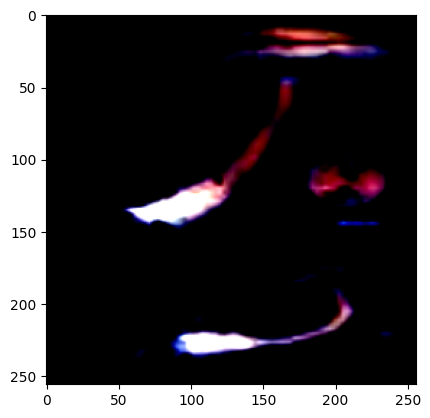

In [110]:
# Get sample immage
import matplotlib.pyplot as plt

images, labels = next(iter(train_data_loader))
plt.imshow(np.transpose(images[0], (1, 2, 0)))
print(labels[0])

In [131]:
print(f'total number of images is {32*len(data_loader)}')

total number of images 38400


In [144]:
## Possible GPU acceleration

if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cpu.


In [145]:
## Function to calculate accuracy score

from sklearn.metrics import accuracy_score
def get_acc(y_pred, y_true):
    return accuracy_score(y_true, y_pred)

In [148]:
# Model train with 30 epoch

optimizer = torch.optim.Adam(resnet18.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

for epoch in range(30):
    bce_loss = nn.CrossEntropyLoss()
    resnet18.train()
    running_train_loss = 0.
    running_val_loss = 0.

    running_train_acc = 0.
    running_val_acc = 0.

    for i, data in enumerate(train_data_loader):
        images, labels = data
        images, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        pred_labels = resnet18.forward(images)

        loss = bce_loss(pred_labels, labels)

        loss.backward()
        optimizer.step()

        running_train_acc += get_acc(torch.argmax(pred_labels, dim = 1).detach().numpy(), labels.detach().numpy())
        print(running_train_acc)
        running_train_loss += loss.item()


    model.eval()
    for i, data in enumerate(val_data_loader):

        images_val, labels_val = data
        images_val, labels_val = images_val.to(device), labels_val.to(device)


        y_pred_labels = model.forward(images_val)
        val_loss = be_loss(y_pred_labels, labels_val)

        running_val_loss += val_loss
        running_val_acc += get_acc(torch.argmax(y_pred_labels, dim = 1).detach().numpy(), labels_val.detach().numpy())

    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_data_loader)

    avg_train_acc = running_train_acc / len(train_loader)
    avg_val_acc = running_val_loss / len(val_data_loader)

    print(f'Epoch {epoch+1} | Training Loss: {avg_train_loss} | Training Accuracy {avg_train_acc}\
                            | Validation loss {avg_val_loss} | Validation Accuracy {avg_val_acc}')

0.03125
0.0625
0.0625
0.09375
0.09375
0.125
0.15625
0.15625
0.15625
0.15625
0.21875
0.28125
0.3125
0.34375
0.40625
0.40625
0.46875
0.5
0.5625
0.59375
0.59375
0.625
0.6875
0.6875
0.71875
0.71875
0.71875


KeyboardInterrupt: 

In [4]:
# Download miniImageNet & EuroSAT(RGB)

# Split miniImageNet into training

# Pretrain a model
# ResNet10 / ResNet18 / VGG / Vision Transformer / etc

# Validate on validation set 

# Evaluate on test set

# Save pretrained model

# Choose 100 images from EuroSAT dataset
# 25 samples for 5 categories

# Randomly choose 25 images as training set
# 5 images for 5 categories

# Fine-tune the pretrained model

# Test model on the rest 75 samples
# Show results

# fine-tuning several times on different 100 EuroSAT images

# Get their average result


### Compare the performance of different models (ResNet18, VGG, Vision Transformer, etc.), and investigate the different optimization strategies. (This part will be used as a bonus item, 2 points)

In [2]:
# Use other models
# ResNet10 / ResNet18 / VGG / Vision Transformer / etc

# Use different optimization strategies

# Compare the performance


### If it’s possible, you can evaluate on the other datasets such as CropDiseases, CUB, ISIC, ChestX, etc. (This part will be used as a bonus item, 2 points)

In [3]:
# Evaluate on other datasets
# CropDiseases / CUB / ISIC / ChestX / etc
